<a href="https://colab.research.google.com/github/risker93/Hello_World/blob/main/kaggle_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU

In [ ]:
item_categories = pd.read_csv('/content/drive/MyDrive/data/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/data/items.csv')
#sales_train = pd.read_csv('/content/drive/MyDrive/data/sales_train.csv') #학습데이터
sample_submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
shops = pd.read_csv('/content/drive/MyDrive/data/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/data/test.csv')#테스트 데이터


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/data/sales_train.csv' ) #학습데이터


In [ ]:
raw_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
df = raw_data.copy()

In [ ]:
#1.train에 중복값 제거 (train의 모든 컬럼값이 동일한 value를 삭제)
# drop_duplicates
subset= ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(df.duplicated(subset=subset).value_counts())
df.drop_duplicates(subset=subset, inplace=True)
# 2935849 - 2935825 = 24개의 중복데이터 삭제

False    2935825
True          24
dtype: int64


In [ ]:
#2.test에 있는 세일즈수만 예측하면되기때문에 train에서 test에 없는 상품 제거
#test_shops = test.shop_id.unique()
#test_items = test.item_id.unique()
#df = df[df.shop_id.isin(test_shops)]
#df = df[df.item_id.isin(test_items)]
#df.shape
# 기존2935825에서1224429으로 절반 이상 데이터 드랍

In [ ]:
df2 = df

In [ ]:
df2 = df.rename_axis('ID2').reset_index()

In [ ]:
df2

,ID2,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,02.01.2013,0,59,22154,999.00,1.0
1,1,03.01.2013,0,25,2552,899.00,1.0
2,2,05.01.2013,0,25,2552,899.00,-1.0
3,3,06.01.2013,0,25,2554,1709.05,1.0
4,4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...,...
2935820,2935844,10.10.2015,33,25,7409,299.00,1.0
2935821,2935845,09.10.2015,33,25,7460,299.00,1.0
2935822,2935846,14.10.2015,33,25,7459,349.00,1.0
2935823,2935847,22.10.2015,33,25,7440,299.00,1.0


In [ ]:
df2= df2[(df2['item_cnt_day'] < df2['item_cnt_day'].quantile(0.95))]

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])

In [ ]:
df2

,ID2,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2013-02-01,0,59,22154,999.00,1.0
1,1,2013-03-01,0,25,2552,899.00,1.0
2,2,2013-05-01,0,25,2552,899.00,-1.0
3,3,2013-06-01,0,25,2554,1709.05,1.0
4,4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...,...
2935820,2935844,2015-10-10,33,25,7409,299.00,1.0
2935821,2935845,2015-09-10,33,25,7460,299.00,1.0
2935822,2935846,2015-10-14,33,25,7459,349.00,1.0
2935823,2935847,2015-10-22,33,25,7440,299.00,1.0


In [ ]:
df2 = df2.drop('ID2',axis=1)

In [ ]:
df2['date'] = df2['date'].sort_values()

In [ ]:
df2 = df2.reset_index()

In [ ]:
df2 = df2.drop('index', axis=1)

In [ ]:
df2 = df2.rename_axis('ID').reset_index()

In [ ]:
df2

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2013-02-01,0,59,22154,999.00,1.0
1,1,2013-03-01,0,25,2552,899.00,1.0
2,2,2013-05-01,0,25,2552,899.00,-1.0
3,3,2013-06-01,0,25,2554,1709.05,1.0
4,4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...,...
2636699,2636699,2015-10-10,33,25,7409,299.00,1.0
2636700,2636700,2015-09-10,33,25,7460,299.00,1.0
2636701,2636701,2015-10-14,33,25,7459,349.00,1.0
2636702,2636702,2015-10-22,33,25,7440,299.00,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f127a2e6d90>,
      dtype=object)

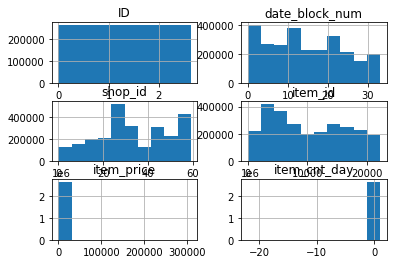

In [ ]:
df2.hist()

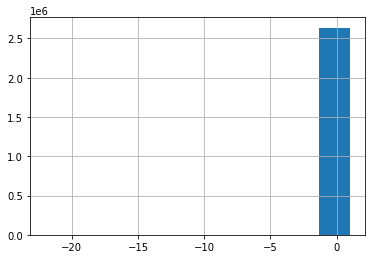

In [ ]:
df2['item_cnt_day'].hist()

In [ ]:
df2['item_cnt_day'].quantile(0.95)

1.0

In [ ]:
df2.head()

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2013-02-01,0,59,22154,999.00,1.0
1,1,2013-03-01,0,25,2552,899.00,1.0
2,2,2013-05-01,0,25,2552,899.00,-1.0
3,3,2013-06-01,0,25,2554,1709.05,1.0
4,4,2013-01-15,0,25,2555,1099.00,1.0


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636704 entries, 0 to 2636703
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   ID              int64         
 1   date            datetime64[ns]
 2   date_block_num  int64         
 3   shop_id         int64         
 4   item_id         int64         
 5   item_price      float64       
 6   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 140.8 MB


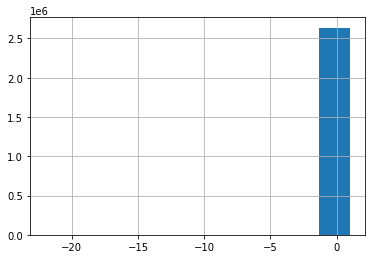

In [ ]:
df2['item_cnt_day'].hist()

In [ ]:
df2

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2013-02-01,0,59,22154,999.00,1.0
1,1,2013-03-01,0,25,2552,899.00,1.0
2,2,2013-05-01,0,25,2552,899.00,-1.0
3,3,2013-06-01,0,25,2554,1709.05,1.0
4,4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...,...
2636699,2636699,2015-10-10,33,25,7409,299.00,1.0
2636700,2636700,2015-09-10,33,25,7460,299.00,1.0
2636701,2636701,2015-10-14,33,25,7459,349.00,1.0
2636702,2636702,2015-10-22,33,25,7440,299.00,1.0


In [ ]:
df2 = df2.drop(['date_block_num'],axis=1)

In [ ]:
df2 = df2.drop(['item_price'],axis=1)

In [ ]:
df2

,ID,date,shop_id,item_id,item_cnt_day
0,0,2013-02-01,59,22154,1.0
1,1,2013-03-01,25,2552,1.0
2,2,2013-05-01,25,2552,-1.0
3,3,2013-06-01,25,2554,1.0
4,4,2013-01-15,25,2555,1.0
...,...,...,...,...,...
2636699,2636699,2015-10-10,25,7409,1.0
2636700,2636700,2015-09-10,25,7460,1.0
2636701,2636701,2015-10-14,25,7459,1.0
2636702,2636702,2015-10-22,25,7440,1.0


In [ ]:
df3 = df2.set_index('date')

In [ ]:
df3.head()

,ID,shop_id,item_id,item_cnt_day
date,,,,
2013-02-01,0,59,22154,1.0
2013-03-01,1,25,2552,1.0
2013-05-01,2,25,2552,-1.0
2013-06-01,3,25,2554,1.0
2013-01-15,4,25,2555,1.0


In [ ]:
df4 = df3.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].resample('M').sum()

In [ ]:
df5 = pd.DataFrame(df4)

In [ ]:
df5 = df5.reset_index()

In [ ]:
df5 = df5.drop('date',axis=1)

In [ ]:
df5 = df5.rename_axis('ID').reset_index()

In [ ]:
df5

,ID,shop_id,item_id,item_cnt_day
0,0,0,31,5.0
1,1,0,32,2.0
2,2,0,32,2.0
3,3,0,32,0.0
4,4,0,32,0.0
...,...,...,...,...
3818908,3818908,59,22167,0.0
3818909,3818909,59,22167,0.0
3818910,3818910,59,22167,0.0
3818911,3818911,59,22167,0.0


In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
df6 = pd.merge(df5, items, how='left', left_on='item_id',right_on='item_id')

In [ ]:
df6 = df6.drop('item_name',axis=1)

In [ ]:
y = df6.loc[:,'item_cnt_day']
X = df6.drop(['item_cnt_day'], axis=1)

In [ ]:
X

,ID,shop_id,item_id,item_category_id
0,0,0,31,37
1,1,0,32,40
2,2,0,32,40
3,3,0,32,40
4,4,0,32,40
...,...,...,...,...
3818908,3818908,59,22167,49
3818909,3818909,59,22167,49
3818910,3818910,59,22167,49
3818911,3818911,59,22167,49


In [ ]:
#df_test_orig = df3.loc[:, ['shop_id', 'item_id', 'item_cnt_day']]

In [ ]:
y

0          5.0
1          2.0
2          2.0
3          0.0
4          0.0
          ... 
3818908    0.0
3818909    0.0
3818910    0.0
3818911    0.0
3818912    1.0
Name: item_cnt_day, Length: 3818913, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [ ]:
# 학습과 테스트 데이터 분리
#split = "2015-01-01"
#df_train = df3[:split]
#df_test = df3[split:]

#df_train_y = df_train.loc[:,'item_cnt_day']
#df_train_x = df_train.drop('item_cnt_day', axis=1)
#df_test_y = df_test.loc[:,'item_cnt_day']
#df_test_x = df_test.drop('item_cnt_day', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
#df_test_orig = df_test.loc[:, ['shop_id', 'item_id', 'item_cnt_day']]

In [ ]:
XG_model_month = XGBRegressor()
XG_model_month.fit(X_train, y_train,
                   eval_set=[(X_test, y_test)],
                   early_stopping_rounds=10,verbose=False)


[00:15:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
pred = XG_model_month.predict(X_test)
print(mean_absolute_error(y_test, pred))
print(sqrt(mean_squared_error(y_test, pred)))

0.7240216107995043
1.0243688831065882


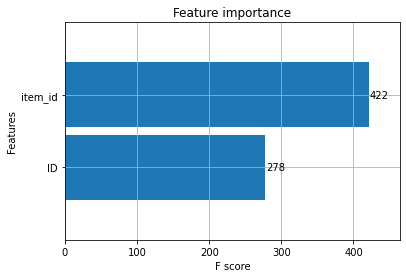

In [ ]:
# 주요하게 적용하는 변수를 판단
from xgboost import plot_importance

import matplotlib.pyplot as plt

%matplotlib inline

plot_importance(XG_model_month, height=0.9)

In [ ]:
#xgboost = XG_model_month.predict(df3)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
#result=pd.concat([df_test_orig[(df_test_orig.store==1)&(df_test_orig.item==2)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
#result = result.set_index('date')
#result = result.loc[:, ['item_cnt_day', 'xgboost']]
#result.plot()

In [ ]:
test2=test.copy()

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [ ]:
test2 = pd.merge(test2,items, how='left', left_on='item_id',right_on='item_id')

In [ ]:
test2=test2.drop('item_name', axis=1)

In [ ]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   ID                214200 non-null  int64
 1   shop_id           214200 non-null  int64
 2   item_id           214200 non-null  int64
 3   item_category_id  214200 non-null  int64
dtypes: int64(4)
memory usage: 8.2 MB


In [ ]:
test2.astype(float)

,ID,shop_id,item_id,item_category_id
0,0.0,5.0,5037.0,19.0
1,1.0,5.0,5320.0,55.0
2,2.0,5.0,5233.0,19.0
3,3.0,5.0,5232.0,23.0
4,4.0,5.0,5268.0,20.0
...,...,...,...,...
214195,214195.0,45.0,18454.0,55.0
214196,214196.0,45.0,16188.0,64.0
214197,214197.0,45.0,15757.0,55.0
214198,214198.0,45.0,19648.0,40.0


In [ ]:
pred = XG_model_month.predict(test2)
submission = pd.DataFrame(pred)
submission_copy = submission.rename_axis('ID').reset_index()


In [ ]:
submission_copy

,ID,0
0,0,0.762114
1,1,0.762114
2,2,0.762114
3,3,0.762114
4,4,0.762114
...,...,...
214195,214195,0.492836
214196,214196,0.549030
214197,214197,0.549030
214198,214198,0.492836


In [ ]:
submission_copy.columns = ['ID', 'item_cnt_month']

In [ ]:
submission_copy

,ID,item_cnt_month
0,0,0.859326
1,1,0.550553
2,2,0.764808
3,3,0.685739
4,4,0.808498
...,...,...
214195,214195,0.444768
214196,214196,0.564151
214197,214197,0.446630
214198,214198,0.517434


In [ ]:
submission_copy.mean()

ID                107099.500000
item_cnt_month         0.584019
dtype: float64

In [ ]:

#submission_copy['item_cnt_month'] = submission_copy['item_cnt_month'].astype(float)
submission_copy.to_csv('XG_submission_final.csv',index=False)